In [1]:
import qiime2 as q2
import pandas as pd
import numpy as np
import skbio
import os
import biom

import scipy.stats as ss
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2.plugins import diversity, feature_table, gemelli
#gemelli

In [2]:
data_dir = '../Updated_Data/final_tables/'
data_dict_16s = {
    'full_table': q2.Artifact.load(data_dir + 'full_table.qza'), 
    'unmedicated': q2.Artifact.load(data_dir + 'unmedicated_table.qza'),
    'medicated': q2.Artifact.load(data_dir + 'medicated_table.qza')
}

gg2_tree = q2.Artifact.load('../Updated_Data/2022.10.phylogeny.asv.nwk.qza')
metadata = pd.read_csv(data_dir + 'metadata_full.tsv', sep='\t', index_col=0)

In [3]:
def generate_dms(): 
    for distance_metric in ['uwuf', 'wuf', 'rpca']: 
        table = q2.Artifact.load('../Updated_Data/final_tables/full_table.qza')
        rare = feature_table.methods.rarefy(table=table, sampling_depth=5000).rarefied_table
        if distance_metric == 'rpca': 
            gemelli_out = gemelli.methods.rpca(table=rare)
            biplot = gemelli_out.biplot
            dm = gemelli_out.distance_matrix
        elif distance_metric == 'uwuf':
            dm = diversity.pipelines.beta_phylogenetic(table=rare, phylogeny=gg2_tree, 
                                                       metric='unweighted_unifrac').distance_matrix
        elif distance_metric == 'wuf': 
            dm = diversity.pipelines.beta_phylogenetic(table=rare, phylogeny=gg2_tree, 
                                                       metric='weighted_unifrac').distance_matrix

        if distance_metric in ['uwuf', 'wuf']: 
            pcoa = diversity.methods.pcoa(distance_matrix = dm, number_of_dimensions=3).pcoa
            rel_freq = feature_table.methods.relative_frequency(table=table).relative_frequency_table
            biplot = diversity.methods.pcoa_biplot(pcoa=pcoa, features=rel_freq).biplot

        dm.save(distance_metric + '_distance_matrix.qza') 
        biplot.save(distance_metric + '_biplot.qza')

In [4]:
def get_biplot(distance_metric, phylogeny=None): 
    dm = q2.Artifact.load(distance_metric + '_distance_matrix.qza') 
    biplot = q2.Artifact.load(distance_metric + '_biplot.qza')
    return dm.view(skbio.DistanceMatrix), biplot.view(skbio.OrdinationResults)

In [27]:
def make_pcoa(bt, md, column, xpos=0, ypos=0, phylogeny=None, distance_metric='rpca', title='RPCA Ordination', 
              custom_labels=None, custom_title='Diagnosis', path_to_save=None, palette='viridis'): 
    dm, biplot = get_biplot(distance_metric, phylogeny)
    
    md = md.loc[md.index.intersection(bt.view(biom.Table).ids())]
    ordination = biplot.samples.merge(md[[column]], right_index=True, left_index=True)
 
    sns.scatterplot(data=ordination, x=0, y=1, hue=column, palette=palette)
    pc2_prop = str(np.round(biplot.proportion_explained[1]*100, 2))
    pc1_prop = str(np.round(biplot.proportion_explained[0]*100, 2))
    plt.ylabel('PC2 (' + pc2_prop + '%)', fontsize=13)
    plt.xlabel('PC1 (' + pc1_prop + '%)', fontsize=13)
    plt.title(title, fontdict={'size': 14, 'weight': 'bold'})
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    dm = dm.filter(bt.view(biom.Table).ids())
    perm_out = skbio.stats.distance.permanova(dm, md, column)
    f_stat = str(np.round(perm_out['test statistic'], 3))
    p_val = str(perm_out['p-value'])
    
    if custom_labels is not None: 
        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), handles=handles[:2], labels=custom_labels, 
                   title=custom_title, title_fontsize=12)
    else: 
        plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), title=custom_title, fontsize=12, title_fontsize=12)
    plt.text(xpos, ypos, 'F=' + f_stat + ', p=' + p_val, size=14)
    if path_to_save is not None:
        plt.tight_layout()
        plt.savefig(path_to_save)
    plt.show()

In [6]:
def calculate_permanova(bt, md, column, phylogeny=None, metrics=['rpca', 'uwuf', 'wuf']):
    out_df = pd.DataFrame(columns=['pseudo_f', 'p_value'], index=metrics)
    for m in metrics:
        dm, _ = get_biplot(m, phylogeny)
        dm = dm.filter(bt.ids())
        perm_out = skbio.stats.distance.permanova(dm, md, column)
        out_df['pseudo_f'][m] = np.round(perm_out['test statistic'], 3)
        out_df['p_value'][m] = perm_out['p-value']
    return out_df

In [7]:
def calculate_perm_across_groups_cols(bt_dict, md, columns, phylogeny, metrics=['rpca', 'uwuf', 'wuf'], 
                                      iterations=1): 
    list_of_perm_res = []
    for i in range(iterations):
        generate_dms()
        for k in bt_dict: 
            bt = bt_dict[k].view(biom.Table)
            if k == 'unmedicated': 
                cols = ['Gender', 'DX_MDD', 'DX_ANX', 'cobre']
            else: 
                cols = columns 
            for c in cols: 
                perm_df = calculate_permanova(bt, md, c, phylogeny)
                perm_df = perm_df.reset_index() 
                perm_df.rename(columns={'index': 'metric'}, inplace=True)
                perm_df['column'] = c
                perm_df['iteration'] = i
                perm_df['subset'] = k
                list_of_perm_res.append(perm_df)

    return pd.concat(list_of_perm_res)

In [25]:
all_results = calculate_perm_across_groups_cols(data_dict_16s, metadata, ['Gender', 'DX_MDD', 'DX_ANX', 
                                                                          'N06A_Antidepressants', 
                                                                          'N05B_Anxiolytics', 'cobre'], 
                                                gg2_tree, iterations=10)
all_results.to_csv('../Updated_Results/iterations_ordination.tsv', sep='\t')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/4255c82e-849c-474a-95d9-765a594fa432/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-oxekt4hx

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1fbb8da0-bb62-4027-9da2-5bd979d01744/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/15cf9d21-6c2f-471d-9613-16e9f4f3a780/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-rpyei00k

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/6cfb5343-2cc0-4d7b-b442-823c31428128/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/470d6e55-fa9e-485a-8787-032dbd577663/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-9tiwl6yp

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/fbc18d66-a775-4b59-a42b-cb37923e69e3/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/c8393665-e51c-47a1-938e-644ca53b26c0/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-p7s61t42

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/7bdc2392-c051-4114-9b02-ebe0172930d7/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/cce449bd-cc0a-4bf5-8f8f-1ea03123a9ba/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-gag64iwk

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/be3d14a2-43cb-4cc2-8bcd-ce771b55d579/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/2954bc7f-b856-4e36-8009-43b7018015cd/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-2jfdz9hb

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/56086710-8a72-4ba8-bc30-d4590578bab2/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/f0cfdac5-bf1a-40c9-96d1-d4bffb827c0f/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-6btn94rf

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/73d1bed6-4da1-4082-9592-1e12c792ee2d/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/5fd2492b-fbb1-406b-a212-d690c93203bb/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-ag48rl4h

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/d87b7301-bbb4-49c2-ab56-3ee29d564ee0/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/13279c8c-35ec-4c23-8dd9-179d24c2f5e1/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-bfa6yaih

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/b9ac34cf-fb5c-43f7-913e-e835f9346643/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/067818ff-6770-4fb7-8503-dda3a8241744/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-_iphybt6

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/68060250-04cb-451c-8696-5c26c9208112/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [8]:
all_results = pd.read_csv('../Updated_Results/iterations_ordination.tsv', sep='\t', index_col=0)

In [9]:
all_results.loc[all_results['p_value'] < 0.005].sort_values(by='pseudo_f')

,metric,pseudo_f,p_value,column,iteration,subset
1,uwuf,2.102,0.003,cobre,6,unmedicated
1,uwuf,2.131,0.003,cobre,4,unmedicated
1,uwuf,2.172,0.004,cobre,5,unmedicated
1,uwuf,2.191,0.003,cobre,3,unmedicated
1,uwuf,2.284,0.004,Gender,3,unmedicated
...,...,...,...,...,...,...
0,rpca,13.880,0.001,Gender,2,full_table
0,rpca,14.019,0.001,Gender,9,full_table
0,rpca,14.277,0.001,Gender,0,full_table
0,rpca,14.613,0.001,Gender,7,full_table


In [10]:
full_results = all_results.loc[all_results.subset == 'full_table']
unmedicated_results = all_results.loc[all_results.subset == 'unmedicated']

medicated_results = all_results.loc[all_results.subset == 'medicated']

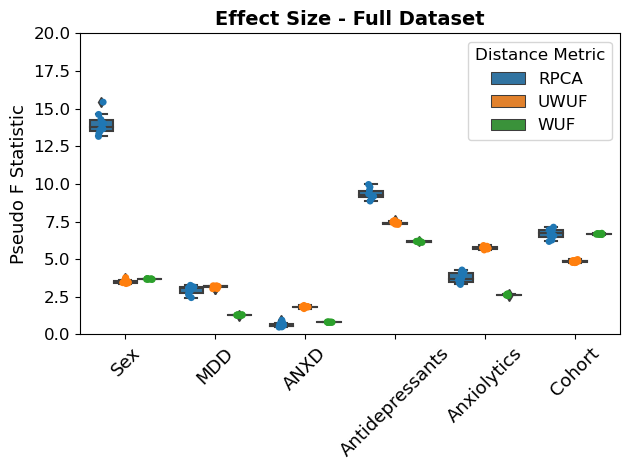

In [11]:
sns.boxplot(data=full_results, x='column', y='pseudo_f', hue='metric')
sns.stripplot(data=full_results, x='column', y='pseudo_f', hue='metric', dodge=True)

ax = plt.gca()
ax.set_xticklabels(['Sex', 'MDD', 'ANXD', 'Antidepressants', 'Anxiolytics', 'Cohort'], rotation=45, fontsize=13)
plt.yticks(fontsize=12)
ax.set_ylabel('Pseudo F Statistic', fontsize=13)
ax.set_xlabel('')
ax.set_title('Effect Size - Full Dataset', fontdict={'size':14, 'weight':'heavy'})
ax.legend(ax.get_legend_handles_labels()[0], ['RPCA', 'UWUF', 'WUF'], title='Distance Metric', fontsize=12, 
          title_fontsize=12)
ax.set_ylim(0, 20)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig1c.pdf')

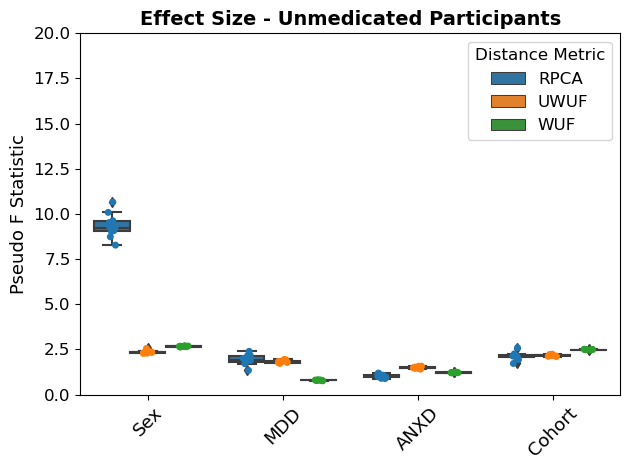

In [12]:
sns.boxplot(data=unmedicated_results, x='column', y='pseudo_f', hue='metric')
sns.stripplot(data=unmedicated_results, x='column', y='pseudo_f', hue='metric', dodge=True)

ax = plt.gca()
ax.set_xticklabels(['Sex', 'MDD', 'ANXD', 'Cohort'], rotation=45, fontsize=13)
ax.set_ylabel('Pseudo F Statistic', fontsize=13)
plt.yticks(fontsize=12)
ax.set_xlabel('')
ax.set_title('Effect Size - Unmedicated Participants', fontdict={'size':14, 'weight':'heavy'})
ax.legend(ax.get_legend_handles_labels()[0], ['RPCA', 'UWUF', 'WUF'], title='Distance Metric', fontsize=12, 
          title_fontsize=12)
ax.set_ylim(0, 20)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig1d.pdf')

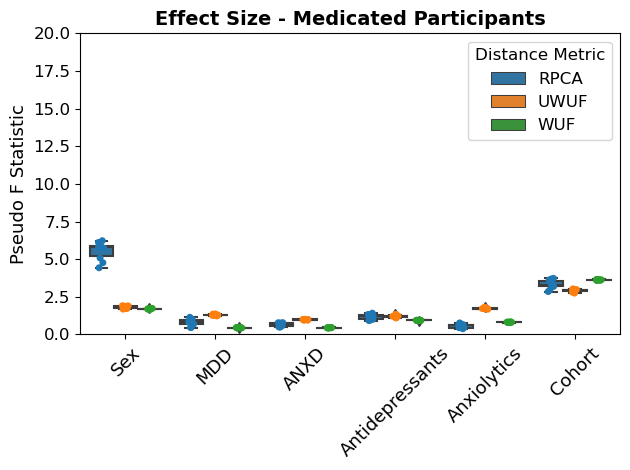

In [13]:
sns.boxplot(data=medicated_results, x='column', y='pseudo_f', hue='metric')
sns.stripplot(data=medicated_results, x='column', y='pseudo_f', hue='metric', dodge=True)

ax = plt.gca()
ax.set_xticklabels(['Sex', 'MDD', 'ANXD', 'Antidepressants', 'Anxiolytics', 'Cohort'], rotation=45, 
                   fontsize=13)
ax.set_ylabel('Pseudo F Statistic', fontsize=13)
plt.yticks(fontsize=12)
ax.set_xlabel('')
ax.set_title('Effect Size - Medicated Participants', fontdict={'size':14, 'weight':'heavy'})
ax.legend(ax.get_legend_handles_labels()[0], ['RPCA', 'UWUF', 'WUF'], title='Distance Metric', fontsize=12, 
          title_fontsize=12)
ax.set_ylim(0, 20)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig1e.pdf')

In [14]:
import adonis

In [15]:
all_res = []
md_q2 = q2.Metadata.load(data_dir+'metadata_full.tsv')
for i in range(10):
    generate_dms()
    dms = {
        'uwuf': q2.Artifact.load('uwuf_distance_matrix.qza'), 
        'wuf': q2.Artifact.load('wuf_distance_matrix.qza'),
        'rpca': q2.Artifact.load('rpca_distance_matrix.qza')
    }
    for dm in dms: 
        for var in ['GroupAssignment', 'DX_MDD', 'DX_ANX']: 
            model = "N06A_Antidepressants+cobre+N05B_Anxiolytics+Gender+Age+InBody_BMI+" + var
            adonis_out = adonis.adonis_and_reformat(dms[dm], md_q2, model, 'adonis_out')
            adonis_out['metric'] = dm
            adonis_out['iteration'] = i
            all_res.append(adonis_out)
all_results = pd.concat(all_res)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1eeba061-8714-43ab-bcfd-771add4c206d/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-x6qxcdt_

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/a8f265d9-fd94-4d6d-ab80-148c58c5cbfd/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/c7695f77-8647-4c6a-a924-b83402fb4db7/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-9vih0wwd

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/790b71de-e7a8-43d4-bb77-56f2a89a855a/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/08f0376f-7ab9-41ef-8b5d-6a331fda3c74/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-a3uhbubx

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/20d66d02-0776-4bc2-bd64-7da311c28824/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/73be3d00-f95f-4545-b900-8ce9cf928c11/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-k6r7ep8t

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/2ac34e2a-2380-4738-af84-121c039bbe62/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/35b9007b-989e-4a36-87ea-0903a92e3871/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-vqq86pi4

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/5d1f6fb7-79d8-425e-99de-94abb3dc839d/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/58ace92f-5812-4c2d-9546-60efe7f118fe/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-nolq0k84

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/eed9cc72-fce7-4300-97b7-553c1159afcb/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/ae64aed2-d57e-4f6d-a03e-445bb012e5a0/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-hbr9akbx

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/32bf4428-e898-4bd0-98c8-0e635bd98279/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/23dc1de9-036c-4acc-bec8-6750bce38e4b/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-356arn66

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/5f773490-e595-4dab-9a50-55e742b7023a/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/27b5e7c1-c122-4e04-b526-b7f4a8284ed4/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-9jod1m0s

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/7651b41a-b0b1-417f-9db2-48f4dabb090b/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/aa4f8ea6-3be9-4170-a967-a6df2678cfe7/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-id8z8s8b

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/c3c18913-0b8c-48f1-850e-857f88dd6ecd/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Users/hazedil/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.3 (2023-03-15) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


In [17]:
#all_results.to_csv('../Updated_Results/iterations_ordination_adonis.tsv', sep='\t')
all_results = pd.read_csv('../Updated_Results/iterations_ordination_adonis.tsv', sep='\t')

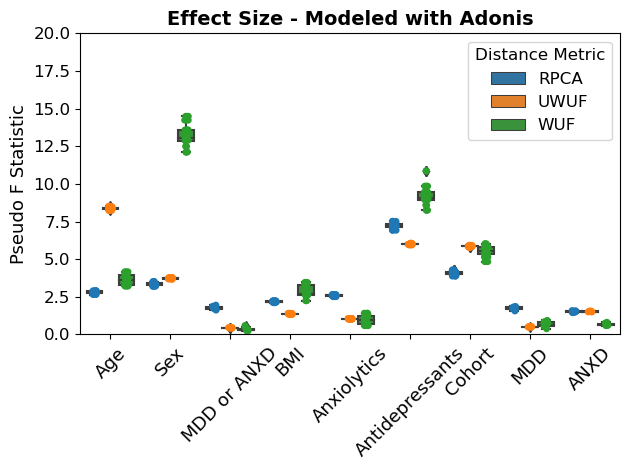

In [20]:
sns.boxplot(data=all_results, x='variable', y='F_stat', hue='metric')
sns.stripplot(data=all_results, x='variable', y='F_stat', hue='metric', dodge=True)
ax = plt.gca()
ax.set_xticklabels(['Age', 'Sex', 'MDD or ANXD', 'BMI', 'Anxiolytics', 'Antidepressants', 'Cohort', 
                    'MDD', 'ANXD',], rotation=45, fontsize=13)
ax.set_ylabel('Pseudo F Statistic', fontsize=13)
plt.yticks(fontsize=12)
ax.set_xlabel('')
ax.set_title('Effect Size - Modeled with Adonis', fontdict={'size':14, 'weight':'heavy'})
ax.legend(ax.get_legend_handles_labels()[0], ['RPCA', 'UWUF', 'WUF'], title='Distance Metric', fontsize=12, 
          title_fontsize=12)
ax.set_ylim(0, 20)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig1f.pdf')

In [21]:
ordination = pd.read_csv('../Updated_Results/iterations_ordination.tsv', sep='\t', index_col=0)
adonis = pd.read_csv('../Updated_Results/iterations_ordination_adonis.tsv', sep='\t', index_col=0)
ordination['analysis_type'] = 'beta_group_significance'
ordination.rename(columns={'column': 'variable'}, inplace=True)
adonis.rename(columns={'F_stat': 'pseudo_f', 'pval': 'p_value'}, inplace=True)
adonis['analysis_type'] = 'adonis'
pd.concat([ordination, adonis]).reset_index(drop=True).to_csv('../Updated_Results/tables2_beta_div_statistics.tsv', sep='\t')

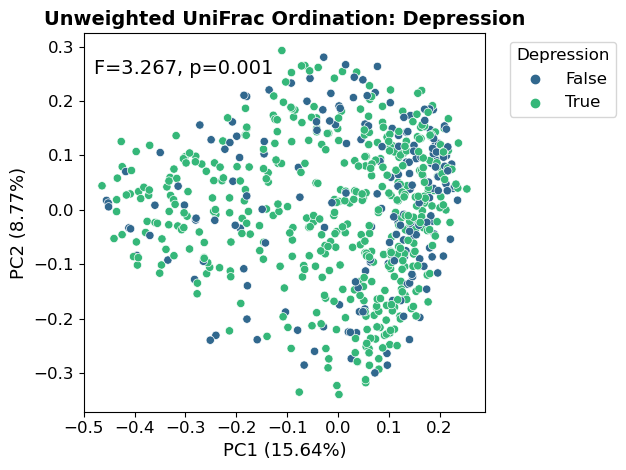

In [28]:
make_pcoa(data_dict_16s['full_table'], metadata, 'DX_MDD', xpos=-0.48, ypos=0.25, distance_metric='uwuf', 
          title='Unweighted UniFrac Ordination: Depression', custom_title='Depression', 
          path_to_save='../Updated_Results/Figures/fig1a.pdf')

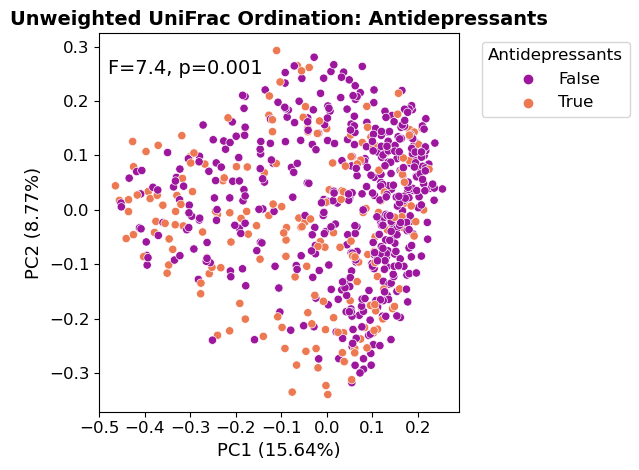

In [29]:
make_pcoa(data_dict_16s['full_table'], metadata, 'N06A_Antidepressants', xpos=-0.48, ypos=0.25, 
          distance_metric='uwuf',
          title='Unweighted UniFrac Ordination: Antidepressants', custom_title='Antidepressants', 
          path_to_save='../Updated_Results/Figures/fig1b.pdf', palette='plasma')